In [1]:
from __future__ import division # always-float division
import numpy as np
import pandas as pd
import glob
import pprint
import os
import requests
from datetime import date

# Easy interactive plots
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Interactive plots in notebook
from IPython.display import HTML, Image, display
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed, Checkbox

# Maths
from scipy.integrate import odeint
import scipy.signal.windows as window
from sklearn.preprocessing import normalize
import scipy.stats as stats

# ISO codes for OWID data
import pycountry 

# Fitter
from lmfit import Model, Parameters, Parameter, report_fit, minimize

# Interactive plot layout options
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

Execution options:
- `STATIC_PLOTS` must be set to `True` to display figures in Github (or a non-JS renderer)
- if `COUNTRY` is not a valid one, it will search France by default
- `DATA_PATH` works just fine with the current repo folders

In [33]:
# Relative path to EPI data folder
DATA_PATH = './data/clean/EPI'
# Studied country for OWID data
COUNTRY = 'France'
DEATHS_FILE = 'total_deaths_10juillet2020.csv'
# Display static (png) plots or interactive plotly (js) figures
STATIC_PLOTS = True

#### Data-getting functions

In [34]:
def download_csv(url, path, prefix):
    """
    Downloads CSV from url
    """
    response = requests.get(url, allow_redirects=True)
    today = str(date.today())
    filepath = f'{path}/{prefix}_{today}.csv'
    open(filepath, 'wb').write(response.content)
    return filepath

def update_owid(path):
    filepath = download_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', path, 'owid')
    print(f'Downloaded Our World In Data Coronavirus data to \n\t{filepath}')
    return filepath

def update_hospitalieres(path):
    filepath = download_csv('https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7', path, 'hospitalieres')
    print(f'Downloaded Données hospitalières Santé Publique data to \n\t{filepath}')
    return filepath

def extract_owid(file, country_code='FRA'):
    """
    Extracts France data from OWID database, creates country attributes from single-valued columns
    """
    # Open, country-filter & relevant column-filer data
    data = pd.read_csv(file, sep=",",header=0)
    countries = data['iso_code'].unique()
    if country_code not in countries:
        country_code = 'FRA'
        print('Invalid country code, extracting France by default')
    data = data[data['iso_code'] == country_code]
    cols = ['date', 'total_cases', 'total_deaths', 'stringency_index', 'population']
    # Drop unnecesary columns
    data = data.drop([c for c in data.columns if c not in cols], axis=1)
    # Get single-valued columns to return as country attribute
    uniques = unique_columns(data)
    attrs = {}
    for col in uniques:
        attrs[col] = data[col].iloc[0]
    # Drop single-valued columns
    data = data.drop(uniques, axis=1)
    data.reset_index(drop=True, inplace=True)
    return data, attrs

def hospitalieres_summary(file):
    """
    Creates national summary database from daily hospitary data per department
    """
    # Open CSV & create df with present dates
    data = pd.read_csv(file, sep=";",header=0)
    new_df = pd.DataFrame()
    dates= data['jour'].unique()
    new_df['date'] = dates
    # Filter data: separate male & female 
    data = data[data['sexe'] != 0]
    # For relevant columns (hospitalized, dead, sent to home, in reanimation) sum for all departments in a given day
    for c in ['hosp', 'rea', 'rad']:
        cum_data = data.groupby('jour')[c].sum().to_numpy()
        # Assign relevant summarized column to storage df
        new_df[c] = cum_data
    return new_df

def datefy(s):
    """
    returns YYYY-MM-DD from YYYY-MM-DD or DD/MM/YYYY
    """
    l2 = s.split('/')
    if len(s.split('-')) == 3:
        return s
    elif len(l2) == 3:
        return '-'.join(reversed(l2))
    else:
        print('Non consistent date format')
        return 'nan'


def country_covid(country, owid_file, hosp_file=''):
    try:
        code = pycountry.countries.search_fuzzy(country)[0].alpha_3
    except LookupError:
        print(f'{country} not found in country dictionary.')
        return
    
    covid_data, country_attrs = extract_owid(owid_file, country_code=code)
    
    if code == 'FRA' and hosp_file != '':
        hosp_database = hospitalieres_summary(hosp_file)
        # Fix date notation
        hosp_database.date = hosp_database.date.apply(lambda s: datefy(s))
        # Mean date duplicates
        hosp_database = hosp_database.groupby(by='date', as_index=False).mean()
        covid_data = hosp_database.merge(covid_data, on='date', how='outer')
        covid_data = covid_data.sort_values(by='date')
        covid_data = covid_data.reset_index(drop=True)
        # Oldest EPI values are all 0 (I, R, D)
        covid_data.loc[0, covid_data.columns != 'date'] = covid_data.loc[0, covid_data.columns != 'date'].apply(lambda x: 0)
        # Forward-fill NaN: old value is maintained until not-NaN value
        covid_data.ffill(axis=0, inplace=True)
        # Rename columns
        covid_data.columns = ['date', 'H', 'Reanimation', 'R', 'I', 'D', 's']
        # Compute S
        covid_data['S'] = country_attrs['population'] - covid_data['I'] - covid_data['D'] - covid_data['H'] - covid_data['Reanimation']
    
    else:
        covid_data = covid_data.sort_values(by='date')
        covid_data = covid_data.reset_index(drop=True)
        # Oldest EPI values are all 0 (I, R, D)
        covid_data.loc[0, covid_data.columns != 'date'] = covid_data.loc[0, covid_data.columns != 'date'].apply(lambda x: 0)
        # Forward-fill NaN: old value is maintained until not-NaN value
        covid_data.ffill(axis=0, inplace=True)
        # Rename columns
        covid_data.columns = ['date', 'I', 'D', 's']
        # Compute S
        covid_data['S'] = country_attrs['population'] - covid_data['I'] - covid_data['D']
    
    covid_data = covid_data[covid_data['I'] > 0]
    covid_data.reset_index(drop=True, inplace=True)
    covid_data['N_effective'] = country_attrs['population'] - covid_data['D']
    covid_data['beta'] = -covid_data['N_effective'] * covid_data['S'].diff() / (covid_data['I'] * covid_data['S'])
    covid_data['mu'] = covid_data['D'].diff() / covid_data['I']
    covid_data.bfill(axis=0, inplace=True)
    
    return covid_data, country_attrs

def unique_columns(df):
    """Return name of columns with an unique value"""
    return [c for c in df.columns if len(df[c].unique()) == 1]

#### Plotting functions

In [35]:
def plot_dualaxis(x, y1, y2, namesy1, namesy2, title='', log_y2=False, static=False):
    if type(y1) != list:
        y1 = [y1]
    if type(y2) != list:
        y2 = [y2]
    if type(namesy1) != list:
        namesy1 = [namesy1, namesy1]
    if type(namesy2) != list:
        namesy2 = [namesy2, namesy2]
    if type(x) == int:
        tspan = np.arange(0, x, 1)
    else:
        tspan = x
        
    scale = 'linear'
    if log_y2:
        scale = 'log'
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    for yi in range(len(y1)):
        fig.add_trace(go.Scatter(x=tspan, y=y1[yi], mode='lines+markers', name=namesy1[yi]))
    for yj in range(len(y2)):
        fig.add_trace(go.Scatter(x=tspan, y=y2[yj], mode='lines+markers', name=namesy2[yj]), secondary_y=True)
    
    fig.update_layout(title=title,
                           xaxis_title='Day',
                           yaxis_title=namesy1[-1],
                           yaxis2_title=namesy2[-1],
                           yaxis2_type=scale,
                           title_x=0.5,
                          width=1000, height=600
                         )

    if static:
        img_bytes = fig.to_image(format="png")
        display(Image(img_bytes))
    else:
        fig.show()

    
def func(s):
#     return normalize([np.convolve(s, window.exponential(10))], norm='max')[0] * np.max(s)
#     return s.diff() * s
    return s.cumsum()
    

def plot_sbeta(df, avg_window=1, show_rawbeta=True, log_y2=False, diff_s=False, static=False):
    tspan = np.arange(0, len(df), 1)
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    if diff_s:
        fig.add_trace(go.Scatter(x=tspan, y=df.beta/df.s, mode='lines+markers', name='diff(s)'), secondary_y=True)
    else:
        fig.add_trace(go.Scatter(x=tspan, y=df.s, mode='lines+markers', name='s'), secondary_y=True)
    if show_rawbeta:
        fig.add_trace(go.Scatter(x=tspan, y=df.beta, mode='lines+markers', name='$\\beta$'))
    if avg_window > 1:
        fig.add_trace(go.Scatter(x=tspan, y=df.beta.rolling(avg_window, center=True).mean(), mode='lines+markers', name=f'$MA(\\beta)_{avg_window}$'))
    
    scale = 'linear'
    if log_y2:
        scale = 'log'
        
    fig.update_layout(title='s and beta over time with variable moving average (MA) window size',
                           xaxis_title='Day',
                           yaxis_title='Transmission rate',
                           yaxis2_title='Stringency',
                           yaxis2_type=scale,
                           title_x=0.5,
                          width=1000, height=600
                         )
    if static:
        img_bytes = fig.to_image(format="png")
        display(Image(img_bytes))
    else:
        fig.show()

## OWID/INSEE data collection & plotting

In [36]:
# Download OWID & Santé Publique data
existing = glob.glob(DATA_PATH+"/*"+str(date.today())+".csv")
if len(existing) != 2:
    owid_file = update_owid(DATA_PATH)
    hosp_file = update_hospitalieres(DATA_PATH)
else:
    owid_file = existing[1]
    hosp_file = existing[0]
    print(f'Our World In Data Coronavirus data available at\n\t{owid_file}\nDonnées hospitalières Santé Publique data available at\n\t{hosp_file}')

Our World In Data Coronavirus data available at
	./data/clean/EPI\owid_2020-07-23.csv
Données hospitalières Santé Publique data available at
	./data/clean/EPI\hospitalieres_2020-07-23.csv


In [37]:
print("Available files:\n\t"+'\n\t'.join(glob.glob(DATA_PATH+"/*")))

Available files:
	./data/clean/EPI\deps_population.csv
	./data/clean/EPI\france.csv
	./data/clean/EPI\france_attrs.csv
	./data/clean/EPI\france_departments.csv
	./data/clean/EPI\hospitalieres_2020-07-06.csv
	./data/clean/EPI\hospitalieres_2020-07-07.csv
	./data/clean/EPI\hospitalieres_2020-07-08.csv
	./data/clean/EPI\hospitalieres_2020-07-09.csv
	./data/clean/EPI\hospitalieres_2020-07-13.csv
	./data/clean/EPI\hospitalieres_2020-07-15.csv
	./data/clean/EPI\hospitalieres_2020-07-16.csv
	./data/clean/EPI\hospitalieres_2020-07-20.csv
	./data/clean/EPI\hospitalieres_2020-07-21.csv
	./data/clean/EPI\hospitalieres_2020-07-22.csv
	./data/clean/EPI\hospitalieres_2020-07-23.csv
	./data/clean/EPI\owid_2020-07-03.csv
	./data/clean/EPI\owid_2020-07-06.csv
	./data/clean/EPI\owid_2020-07-07.csv
	./data/clean/EPI\owid_2020-07-08.csv
	./data/clean/EPI\owid_2020-07-09.csv
	./data/clean/EPI\owid_2020-07-13.csv
	./data/clean/EPI\owid_2020-07-15.csv
	./data/clean/EPI\owid_2020-07-16.csv
	./data/clean/EPI\o

In [38]:
EPI_data, country_attrs = country_covid(COUNTRY, owid_file, hosp_file)
# Add daily deaths data if available
if DEATHS_FILE != '' and COUNTRY == 'France':
    deaths_data = pd.read_csv(DATA_PATH+'/'+DEATHS_FILE, sep=",",header=0)
    EPI_data = EPI_data.merge(deaths_data, on='date', how='outer')
    # Compute collateral deaths
    EPI_data['F'] = EPI_data['D_total'] - EPI_data['D']
    EPI_data.drop(['D_total'], axis=1, inplace=True)
    EPI_data['dD'] = EPI_data['D'].diff()
    EPI_data['dF'] = EPI_data['F'].diff()
    EPI_data.ffill(axis=0, inplace=True)
    EPI_data.bfill(axis=0, inplace=True)
    
    
print(f'COVID-19 data for {COUNTRY}:')
EPI_data.head()

COVID-19 data for France:


,date,H,Reanimation,R,I,D,s,S,N_effective,beta,mu,F,dD,dF
0,2020-01-25,0.0,0.0,0.0,3.0,0.0,11.11,65273509.0,65273512.0,-0.00,0.0,1779.0,0.0,1784.0
1,2020-01-26,0.0,0.0,0.0,3.0,0.0,11.11,65273509.0,65273512.0,-0.00,0.0,1779.0,0.0,1784.0
2,2020-01-27,0.0,0.0,0.0,3.0,0.0,11.11,65273509.0,65273512.0,-0.00,0.0,1779.0,0.0,1784.0
3,2020-01-28,0.0,0.0,0.0,3.0,0.0,11.11,65273509.0,65273512.0,-0.00,0.0,1779.0,0.0,1784.0
4,2020-01-29,0.0,0.0,0.0,4.0,0.0,11.11,65273508.0,65273512.0,0.25,0.0,1779.0,0.0,1784.0


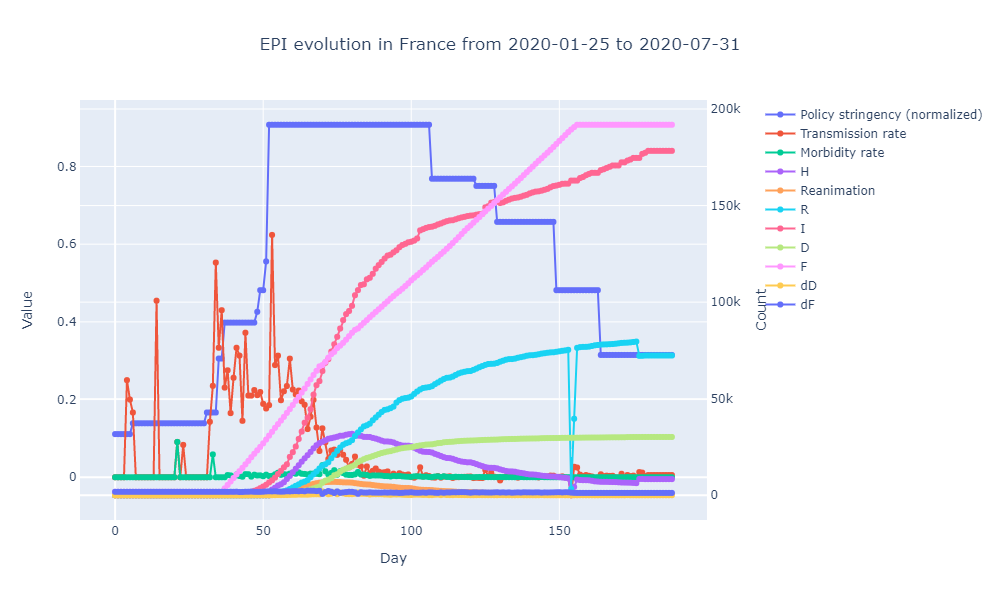

In [39]:
plotcols = [c for c in EPI_data.columns if c not in ['date', 's', 'N_effective', 'beta', 'mu', 'S']]
plot_dualaxis(len(EPI_data),
              [EPI_data[c]/(1 + 99*int(c == 's')) for c in ['s', 'beta', 'mu']],
              [EPI_data[c] for c in plotcols], 
              ['Policy stringency (normalized)', 'Transmission rate', 'Morbidity rate', 'Value'], 
              plotcols + ['Count'], 
              f'EPI evolution in {COUNTRY} from {EPI_data.date[0]} to {EPI_data.date[len(EPI_data)-1]}', 
              log_y2=False,
              static=STATIC_PLOTS)

## From $s$ to $\beta$

In [40]:
interact(plot_sbeta,
        df=fixed(EPI_data),
        avg_window=IntSlider(min=1, max=15, step=1, value=7, description='Window size', style=style, layout=slider_layout),
        show_rawbeta=Checkbox(value=False, description='Show beta(N, D, S, I)'),
        static=fixed(STATIC_PLOTS))

interactive(children=(IntSlider(value=7, description='Window size', layout=Layout(width='99%'), max=15, min=1,…

<function __main__.plot_sbeta(df, avg_window=1, show_rawbeta=True, log_y2=False, diff_s=False, static=False)>

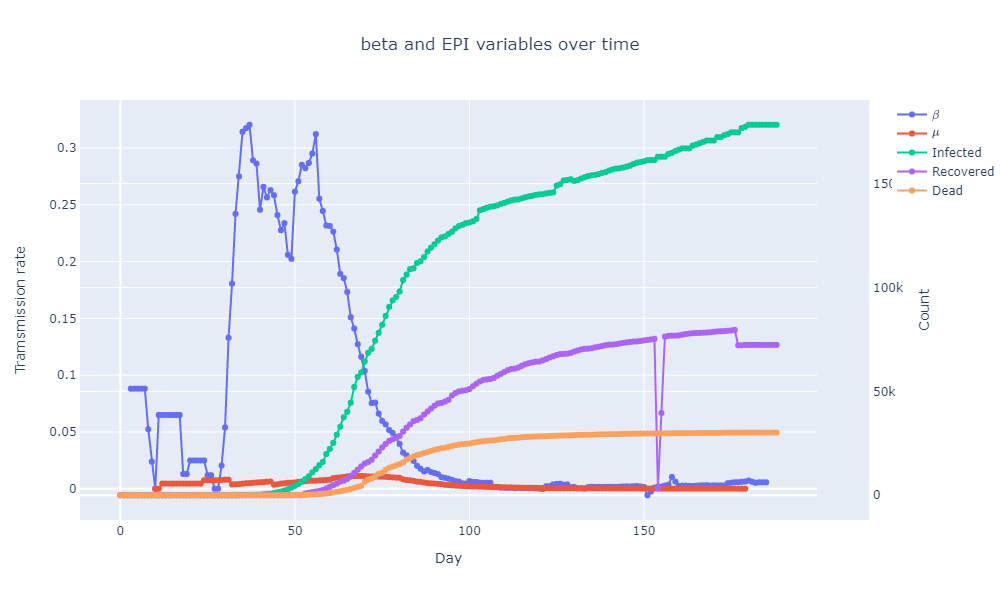

In [41]:
plot_dualaxis(len(EPI_data), 
              [EPI_data.beta.rolling(7, center=True).mean(), EPI_data.mu.rolling(20, center=True).mean()], 
              [EPI_data.I, EPI_data.R, EPI_data.D], 
              ['$\\beta$', '$$\\mu$$', 'Tramsmission rate'], 
              ['Infected', 'Recovered', 'Dead', 'Count'], 
              'beta and EPI variables over time', 
              log_y2=False,
              static=STATIC_PLOTS)

In [42]:
countries = ['France', 'United Kingdom', 'Italy', 'Spain', 'Chile', 'United States', 'India']

Looking for France
Looking for United Kingdom
Looking for Italy
Looking for Spain
Looking for Chile
Looking for United States
Looking for India


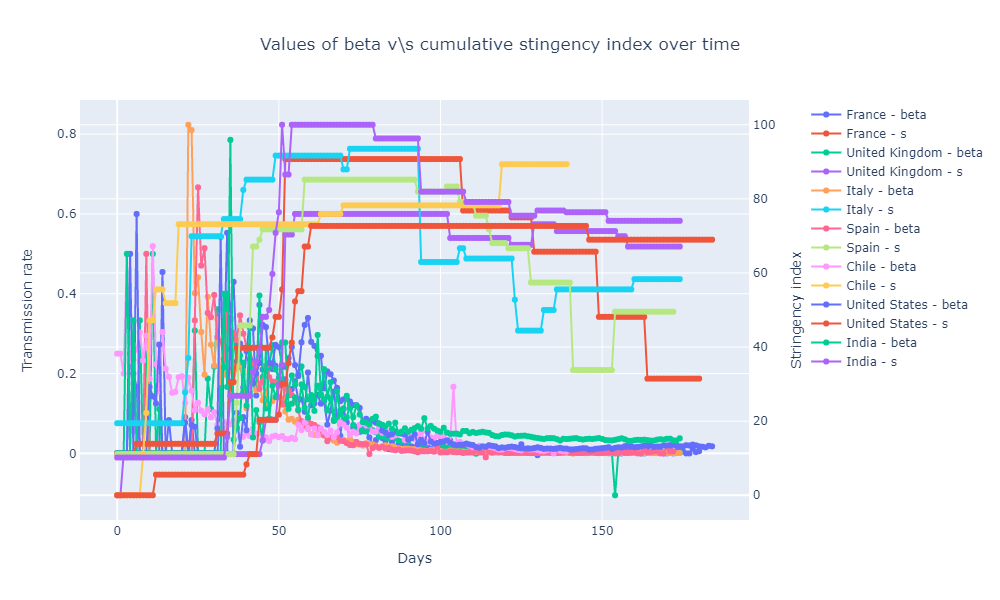

In [43]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

for pays in countries:
    print(f'Looking for {pays}')
    df, _ = country_covid(pays, owid_file)
    fig.add_trace(go.Scatter(x=np.arange(0, len(df), 1), y=df.beta, mode='lines+markers', name=f'{pays} - beta'))
    fig.add_trace(go.Scatter(x=np.arange(0, len(df), 1), y=df.s, mode='lines+markers', name=f'{pays} - s'), secondary_y=True)
    
fig.update_layout(title='Values of beta v\s cumulative stingency index over time',
                       xaxis_title='Days',
                       yaxis_title='Transmission rate',
                       yaxis2_title='Stringency index',
                       title_x=0.5,
                      width=1000, height=600
                     )
if STATIC_PLOTS:
    img_bytes = fig.to_image(format="png")
    display(Image(img_bytes))
else:
    fig.show()

## EPI model

In [44]:
def logistic(x, L, k, x0):
    return L/(1+np.exp(-k*(x-x0)))

def beta_model(t, L1, k1, t1, L2, k2, t2):
    return logistic(t, L1, k1, t1) - logistic(t, L2, k2, t2)

def logistic_params(x, params):
    L, k, x0 = params
    return logistic(x, L, k, x0)

def beta_(t, beta_params):
    L1, k1, t1, L2, k2, t2 = beta_params
    return beta_model(t, L1, k1, t1, L2, k2, t2)

In [51]:
def SIRD_derivs(z, t, rate_params, evo_params):

    S, E, I, R, D, F = z
    N = S + E + I + R + D + F
    
    sigma, gamma, mu, nu = rate_params
    
    beta_params, gamma_params, mu_params = evo_params
    
#     beta = beta_params[3] - logistic(t, beta_params[0], beta_params[1], beta_params[2])
    
    beta= beta_(t, beta_params)
    
#     gamma = gamma_params[0] * stats.gamma.pdf(t, gamma_params[1], scale=gamma_params[2])
#     mu = mu_params[0] * t**2 + mu_params[1] * t + mu_params[2]
    
    
#     gamma = 1 - logistic_params(t, gamma_params)
    mu = mu_params[0] - logistic_params(t, mu_params)
    
    
    
    
    dSdt = -beta*S*I/(N-D) - nu*S
    dEdt = beta*S*I/(N-D) - sigma*E
    dIdt = sigma*E - gamma*I - mu*I
    dRdt = gamma*I
    dDdt = mu*I 
    dFdt = nu*S
    return [dSdt, dEdt, dIdt, dRdt, dDdt, dFdt]

# def beta_(t, beta_params):
#     C, a, b, C2, a2, b2 = beta_params
#     beta = logistic(t, C, a, b) - logistic(t, C2, a2, b2) # Double-logistic (for "extended step")
#     return beta

def ode_solver(t, initial_conditions, params, i):
    initE, initI, initR, initN, initD, initF = initial_conditions
    # Make param lists
    sigma, gamma, mu, nu = params['sigma'].value, params['gamma'].value, params['mu'].value, params['nu'].value
    
    C, a, b = params[f'C_{i}'].value, params[f'a_{i}'].value, params[f'b_{i}'].value
    C2, a2, b2 = params[f'C2_{i}'].value, params[f'a2_{i}'].value, params[f'b2_{i}'].value
    
    gammaC, gammaa, gammab = params[f'gammaC_{i}'].value, params[f'gammaa_{i}'].value, params[f'gammab_{i}'].value
    muC, mua, mub = params[f'muC_{i}'].value, params[f'mua_{i}'].value, params[f'mub_{i}'].value
    
    
    initS = initN - (initE + initI + initR + initD + initF)
    rate_params = [sigma, gamma, mu, nu]
    beta_params = [C, a, b, C2, a2, b2]
    gamma_params = [gammaC, gammaa, gammab]
    mu_params = [muC, mua, mub]
    
    evo_params = [beta_params, gamma_params, mu_params]
    res = odeint(SIRD_derivs, [initS, initE, initI, initR, initD, initF], t, args=(rate_params, evo_params))
    return res

# def error(params, initial_conditions, tspan, data, eps):
#     sol = ode_solver(tspan, initial_conditions, params)
#     # columns S, E, I, R, D
#     return ((sol[:, 2:5] - data)/eps).ravel()

def error_sectors(params, initial_conditions, tspan, data, eps):
    n_sectors = len(initial_conditions)
    sol = np.zeros_like(data)
    for i in range(n_sectors):
        sol_i = ode_solver(tspan, initial_conditions[i], params, i)

        # I   
        sol[:,0] += sol_i[:, 2]
        # D   
        sol[:,1] += sol_i[:, 4]
#         # D   
#         sol[:,2] += sol_i[:, 4]
#         # F   
#         sol[:,2] += sol_i[:, 5]
        
        
    return ((sol - data)/eps).ravel()

def init_sectors(disease_params, sector_props, disease_vary=True):
    assert abs(np.sum(sector_props) - 100) < 0.1, "Sector population proportions aren't normalized"
    sigma, gamma, mu, nu = disease_params
    initial_conditions = []
    params = Parameters()
    for i in range(len(sector_props)):
        initN_i = initN * sector_props[i]/100
        initE_i = 0
        initI_i = 1
        initR_i = 0
        initD_i = 0
        initF_i = 0
        initial_conditions_i = [initE_i, initI_i, initR_i, initN_i, initD_i, initF_i]
        initial_conditions.append(initial_conditions_i)
        params.add(f'C_{i}', value=1, min=0, max=20, vary=True)
        params.add(f'a_{i}', value=1, min=0, max=2, vary=True)
        params.add(f'b_{i}', value=0, min=-100, max=100, vary=True)
        params.add(f'C2_{i}', value=1, min=0, max=20, vary=True)
        params.add(f'a2_{i}', value=1, min=0, max=2, vary=True)
        params.add(f'b2_{i}', value=0, min=-100, max=100, vary=True)
        params.add(f'gammaC_{i}', value=1.0, min=0, max=20, vary=False)
        params.add(f'gammaa_{i}', value=1.0, min=0, max=10, vary=False)
        params.add(f'gammab_{i}', value=1.0, min=0, max=100, vary=False)
        params.add(f'muC_{i}', value=1, min=0, max=20, vary=True)
        params.add(f'mua_{i}', value=0.1, min=0, max=2, vary=True)
        params.add(f'mub_{i}', value=0, min=-100, max=100, vary=True)
        
    params.add('sigma', value=sigma, min=0, max=5.0, vary=disease_vary)
    params.add('gamma', value=gamma, min=0, max=5.0, vary=disease_vary)
    params.add('mu', value=mu, min=0, max=5.0, vary=disease_vary)
    params.add('nu', value=nu, min=0, max=5.0, vary=False)
    
    return params, initial_conditions

def show_rates(result):
    
    pnames = list((result.params.valuesdict()))
    
    b_params = [result.params[p].value for p in pnames[:6]]
#     g_params = [result.params[p].value for p in pnames[6:9]]
    m_params = [result.params[p].value for p in pnames[9:12]]

#     print(b_params)
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=tspan, y=beta_(tspan, b_params), mode='lines+markers', name='Transmission rate'))
    fig.add_trace(go.Scatter(x=tspan, y=m_params[0] - logistic_params(tspan, m_params), mode='lines+markers', name='Morbidity rate'))
    
    fig.add_trace(go.Scatter(x=tspan, y=df.s, mode='lines+markers', name='Stringency'), secondary_y=True)
    
    fig.update_layout(title='Fitted compartment rates & stringency data',
                           xaxis_title='Day',
                           yaxis_title='Value',
                           title_x=0.5,
                          width=1000, height=600
                         )
    if STATIC_PLOTS:
        img_bytes = fig.to_image(format="png")
        display(Image(img_bytes))
    else:
        fig.show()
    

def simulate_plot(result, days, initial_conditions, static=False):
    params = result.params
    tspan = tspan = np.arange(0, days, 1)
    n_sectors = len(initial_conditions)
    sol = np.zeros((days, 3))
    for i in range(n_sectors):
        sol_i = ode_solver(tspan, initial_conditions[i], params, i)
        sol += sol_i[:, 2:5]
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=tspan, y=sol[:, 0], mode='lines+markers', name='Infections'))
    fig.add_trace(go.Scatter(x=tspan, y=sol[:, 1], mode='lines+markers', name='Recovered'))
    fig.add_trace(go.Scatter(x=tspan, y=sol[:, 2], mode='lines+markers', name='Deaths'))
    fig.update_layout(title='SEIRD per sector: Simulation',
                           xaxis_title='Day',
                           yaxis_title='Counts',
                           title_x=0.5,
                          width=1000, height=600
                         )
    if STATIC_PLOTS:
        img_bytes = fig.to_image(format="png")
        display(Image(img_bytes))
    else:
        fig.show()


Database making

In [52]:
def train(country='France', max_days_out=20):
    EPI_data, country_attrs = country_covid(COUNTRY, owid_file, hosp_file)
    # Add daily deaths data if available
    if DEATHS_FILE != '' and COUNTRY == 'France':
        deaths_data = pd.read_csv(DATA_PATH+'/'+DEATHS_FILE, sep=",",header=0)
        EPI_data = EPI_data.merge(deaths_data, on='date', how='outer')
        # Compute collateral deaths
        EPI_data['F'] = EPI_data['D_total'] - EPI_data['D']
        EPI_data.drop(['D_total'], axis=1, inplace=True)
        EPI_data['dD'] = EPI_data['D'].diff()
        EPI_data['dF'] = EPI_data['F'].diff()
        EPI_data.ffill(axis=0, inplace=True)
        EPI_data.bfill(axis=0, inplace=True)
        df = EPI_data.drop(['H', 'Reanimation', 'N_effective', 'beta', 'mu'], axis=1).reindex(columns=['date', 'S', 'I', 'R', 'D', 'F', 's'])
    else:
        df = EPI_data.drop(['N_effective', 'beta', 'mu'], axis=1).reindex(columns=['date', 'S', 'I', 'D', 's'])
    
    df.ffill(axis=0, inplace=True)
    df.bfill(axis=0, inplace=True)
    df = df[df['date'] < str(date.today())]
    initN = country_attrs['population']
    # S0 = 966000000
    initE = 0
    initI = 1
    initR = 0
    initD = 0
    sigma = 1/7 #1/7
    gamma = 1/10 #1/10
    mu = 0.00371 #0.00371

    eps = 1.0
    nu = 0.0

    disease_params = [sigma, gamma, mu, nu]
    disease_vary = True

    sector_props = [100.0]
    params, initial_conditions = init_sectors(disease_params, sector_props, disease_vary=disease_vary)
    data_full = df.loc[0:(len(df)-1), ['I', 'D']].values
    
    error = []
    for out_ in range(max_days_out):
        out_days = out_
        days = len(df) - out_days
        # initial_conditions = [initE, initI, initR, initN, initD]
        tspan = np.arange(1, days+1, 1)
        data = df.loc[0:(days-1), ['I', 'D']].values
        data_s = df.loc[0:(days-1), 's'].values

        print(f'Fitting with {out_days} days out')
        # fit model and find predicted values
        result = minimize(error_sectors, params, args=(initial_conditions, tspan, data, eps), method='leastsq', full_output = 1)
        
        params = result.params
        tspan = np.arange(0, days+out_days, 1)
        n_sectors = len(initial_conditions)
        sol = np.zeros((days+out_days, 2))
        for i in range(n_sectors):
            sol_i = ode_solver(tspan, initial_conditions[i], params, i)
            sol[:,0] += sol_i[:, 2]
            sol[:,1] += sol_i[:, 4]
        
        error.append(np.linalg.norm(sol-data_full))
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=np.arange(0, max_days_out, 1), y=error, mode='lines+markers', name='L2 Error'))
    fig.update_layout(title='Prediction error',
                           xaxis_title='Days removed from data to train',
                           yaxis_title='Value',
                           title_x=0.5,
                          width=1000, height=600
                         )
    if STATIC_PLOTS:
        img_bytes = fig.to_image(format="png")
        display(Image(img_bytes))
    else:
        fig.show()
    


df = EPI_data.drop(['H', 'Reanimation', 'N_effective', 'beta', 'mu'], axis=1).reindex(columns=['date', 'S', 'I', 'R', 'D', 'F', 's'])
df.ffill(axis=0, inplace=True)
df.bfill(axis=0, inplace=True)
df = df[df['date'] < str(date.today())]
df

,date,S,I,R,D,F,s
0,2020-01-25,65273509.0,3.0,0.0,0.0,1779.0,11.11
1,2020-01-26,65273509.0,3.0,0.0,0.0,1779.0,11.11
2,2020-01-27,65273509.0,3.0,0.0,0.0,1779.0,11.11
3,2020-01-28,65273509.0,3.0,0.0,0.0,1779.0,11.11
4,2020-01-29,65273508.0,4.0,0.0,0.0,1779.0,11.11
...,...,...,...,...,...,...,...
175,2020-07-18,65061865.0,174674.0,79354.0,30152.0,191847.0,31.48
176,2020-07-19,65061989.0,174674.0,79576.0,30152.0,191847.0,31.48
177,2020-07-20,65059681.0,174674.0,72180.0,30152.0,191847.0,31.48
178,2020-07-21,65057574.0,176754.0,72209.0,30165.0,191847.0,31.48


Initial parameters & guesses


#SEE https://www.wikiwand.com/en/Gompertz_function

In [53]:
initN = country_attrs['population']
# S0 = 966000000
initE = 0
initI = 1
initR = 0
initD = 0
sigma = 1/7 #1/7
gamma = 1/10 #1/10
mu = 0.00371 #0.00371

eps = 1.0
nu = 0.0

disease_params = [sigma, gamma, mu, nu]
disease_vary = True

sector_props = [100.0]

out_days = 0
days = len(df) - out_days


params, initial_conditions = init_sectors(disease_params, sector_props, disease_vary=disease_vary)
# initial_conditions = [initE, initI, initR, initN, initD]
tspan = np.arange(1, days+1, 1)
data = df.loc[0:(days-1), ['I', 'D']].values
data_s = df.loc[0:(days-1), 's'].values

data_full = df.loc[0:(days+out_days-1), ['I', 'D']].values

In [54]:
# fit model and find predicted values
result = minimize(error_sectors, params, args=(initial_conditions, tspan, data, eps), method='leastsq', full_output = 1)
# display fitted statistics
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1902
    # data points      = 360
    # variables        = 12
    chi-square         = 2.8333e+08
    reduced chi-square = 814163.838
    Akaike info crit   = 4911.36553
    Bayesian info crit = 4957.99877
##  Warning: uncertainties could not be estimated:
    mu:        at initial value
[[Variables]]
    C_0:       18.7949711 (init = 1)
    a_0:       1.66949034 (init = 1)
    b_0:      -6.48476052 (init = 0)
    C2_0:      18.1816602 (init = 1)
    a2_0:      0.12899711 (init = 1)
    b2_0:      59.2176329 (init = 0)
    gammaC_0:  1 (fixed)
    gammaa_0:  1 (fixed)
    gammab_0:  1 (fixed)
    muC_0:     1.30798057 (init = 1)
    mua_0:     0.05119327 (init = 0.1)
    mub_0:    -23.4204430 (init = 0)
    sigma:     0.00758459 (init = 0.1428571)
    gamma:     0.35435106 (init = 0.1)
    mu:        0.00371000 (init = 0.00371)
    nu:        0 (fixed)


180 fitted days out of 180 available data points


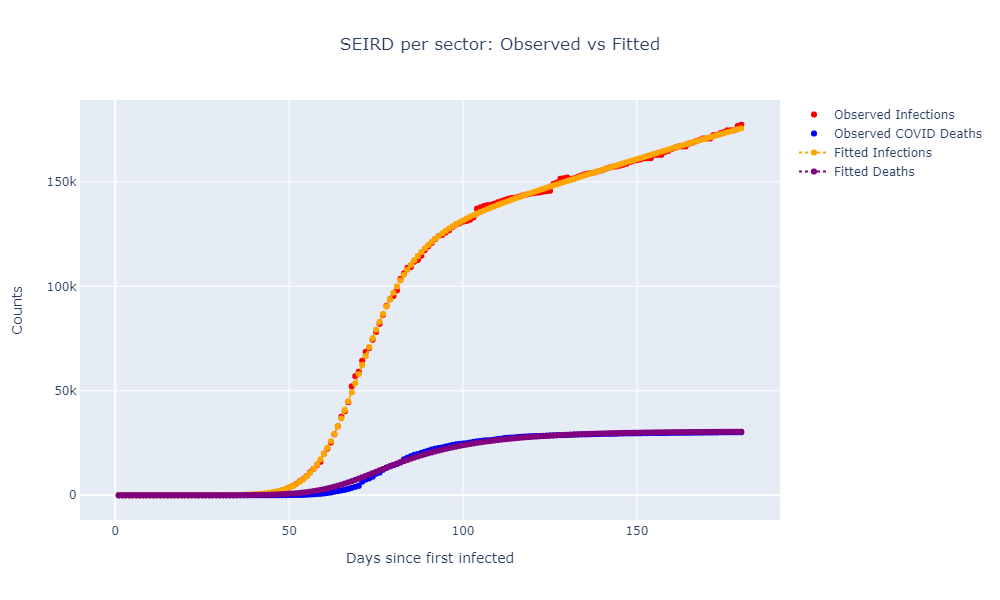

In [55]:
print(f'{days} fitted days out of {days+out_days} available data points')

final = data + result.residual.reshape(data.shape)
tspan_full = np.arange(1, days+out_days+1, 1)

fig = go.Figure()
fig.add_trace(go.Scatter(x=tspan_full, y=data[:, 0], mode='markers', name='Observed Infections',line = dict(dash='dot', color='red')))
# fig.add_trace(go.Scatter(x=tspan_full, y=data[:, 1], mode='markers', name='Observed Recovered', line = dict(dash='dot')))
fig.add_trace(go.Scatter(x=tspan_full, y=data[:, 1], mode='markers', name='Observed COVID Deaths', line = dict(dash='dot', color='blue')))
# fig.add_trace(go.Scatter(x=tspan_full, y=data[:, 2], mode='markers', name='Observed Collateral Deaths', line = dict(dash='dot')))
fig.add_trace(go.Scatter(x=tspan_full, y=final[:, 0], mode='lines+markers', name='Fitted Infections',line = dict(dash='dot', color='orange')))
# fig.add_trace(go.Scatter(x=tspan_full, y=final[:, 1], mode='lines+markers', name='Fitted Recovered'))
fig.add_trace(go.Scatter(x=tspan_full, y=final[:, 1], mode='lines+markers', name='Fitted Deaths',line = dict(dash='dot', color='purple')))
# fig.add_trace(go.Scatter(x=tspan_full, y=final[:, 2], mode='lines+markers', name='Fitted Collateral Deaths'))
if out_days > 0:
    fig.add_trace(go.Scatter(x=tspan_full, y=data_full[:, 0], mode='markers', name='Observed Infections (Full)', line = dict(dash='dot')))
#     fig.add_trace(go.Scatter(x=tspan_full, y=data_full[:, 1], mode='markers', name='Observed Recovered (Full)', line = dict(dash='dot')))
    fig.add_trace(go.Scatter(x=tspan_full, y=data_full[:, 1], mode='markers', name='Observed Deaths (Full)', line = dict(dash='dot')))
#     fig.add_trace(go.Scatter(x=tspan_full, y=data_full[:, 2], mode='markers', name='Observed Collateral Deaths (Full)', line = dict(dash='dot')))
    
fig.update_layout(title='SEIRD per sector: Observed vs Fitted',
                       xaxis_title='Days since first infected',
                       yaxis_title='Counts',
                       title_x=0.5,
                      width=1000, height=600
                     )
if STATIC_PLOTS:
    img_bytes = fig.to_image(format="png")
    display(Image(img_bytes))
else:
    fig.show()

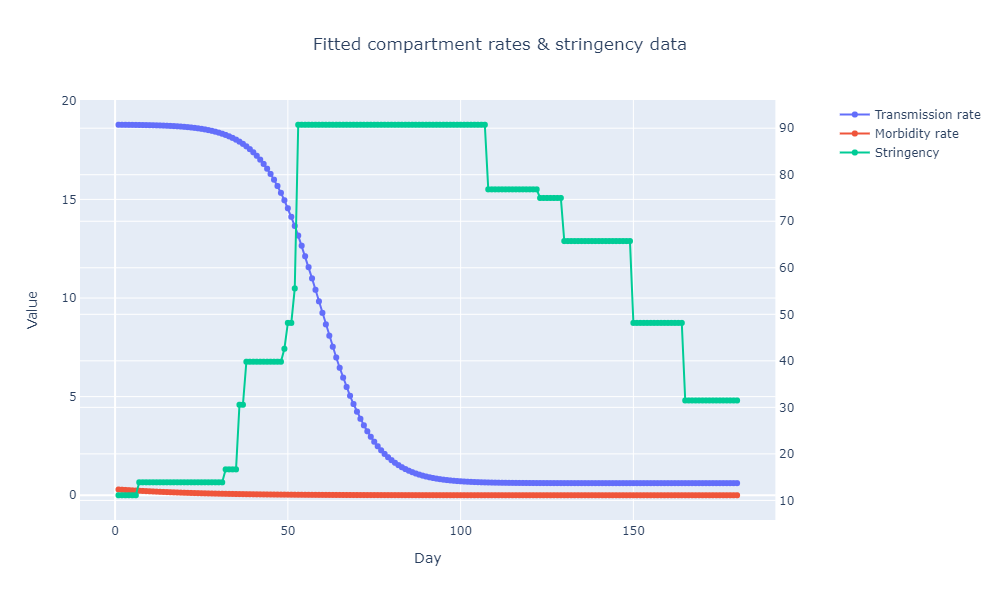

In [56]:
show_rates(result)

Fit on $\beta$

In [261]:
beta_params = [result.params['C_0'].value, result.params['a_0'].value, result.params['b_0'].value, result.params['C2_0'].value, result.params['a2_0'].value, result.params['b2_0'].value]

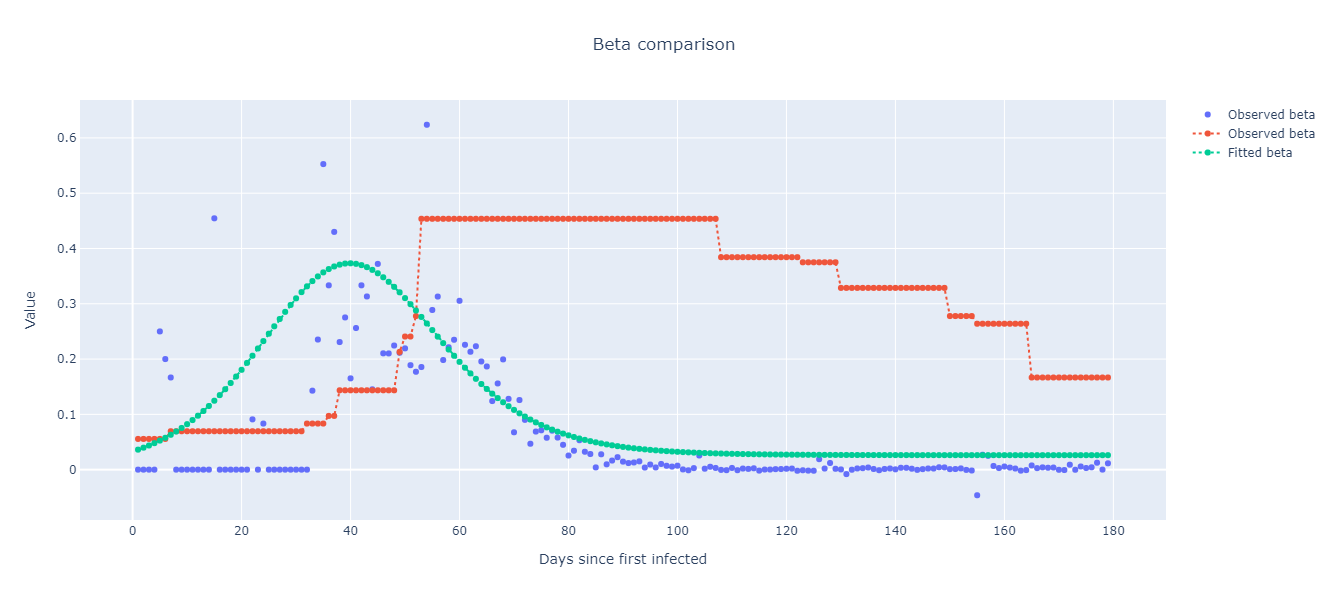

In [262]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=tspan, y=EPI_data.beta, mode='markers', name='Observed beta', line = dict(dash='dot')))
fig.add_trace(go.Scatter(x=tspan, y=EPI_data.s/200, mode='lines+markers', name='Observed beta', line = dict(dash='dot')))
fig.add_trace(go.Scatter(x=tspan, y=beta_(tspan, beta_params), mode='lines+markers', name='Fitted beta', line = dict(dash='dot')))
fig.update_layout(title='Beta comparison',
                       xaxis_title='Days since first infected',
                       yaxis_title='Value',
                       title_x=0.5,
                      width=1000, height=600
                     )
if STATIC_PLOTS:
    img_bytes = fig.to_image(format="png")
    display(Image(img_bytes))
else:
    fig.show()

### Simulation

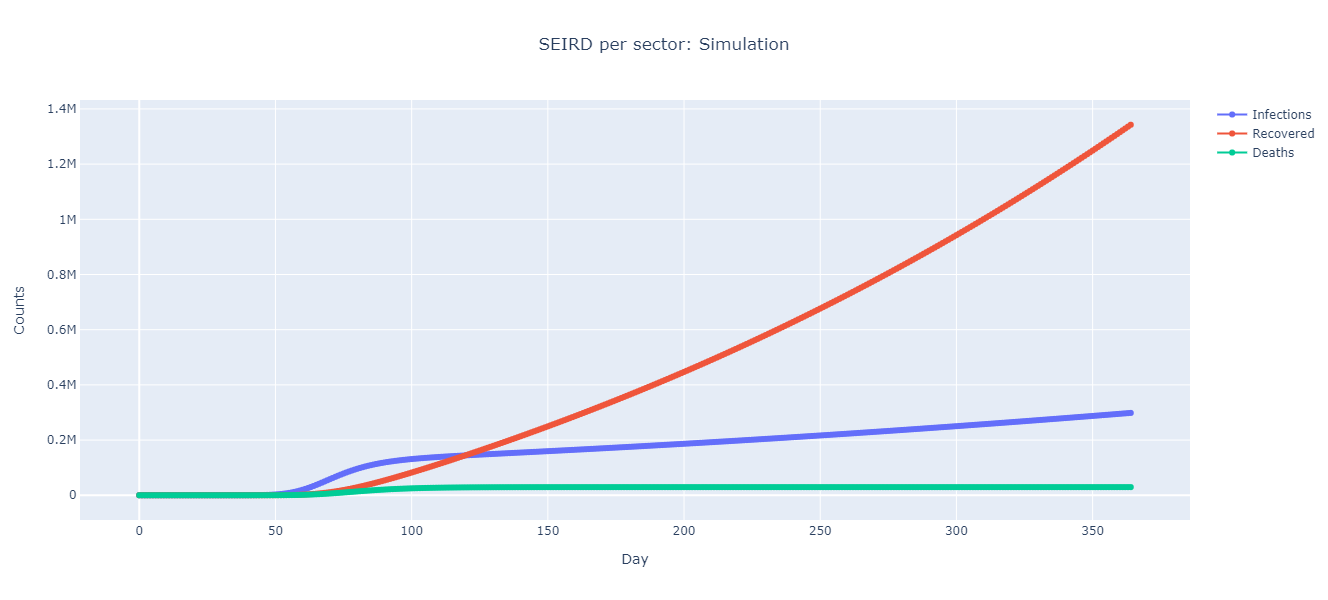

In [263]:
simulation_days = 365
simulate_plot(result, simulation_days, initial_conditions, static=STATIC_PLOTS)

Fitting with 0 days out
Fitting with 1 days out
Fitting with 2 days out
Fitting with 3 days out
Fitting with 4 days out
Fitting with 5 days out
Fitting with 6 days out
Fitting with 7 days out
Fitting with 8 days out
Fitting with 9 days out
Fitting with 10 days out
Fitting with 11 days out
Fitting with 12 days out
Fitting with 13 days out
Fitting with 14 days out
Fitting with 15 days out
Fitting with 16 days out
Fitting with 17 days out
Fitting with 18 days out
Fitting with 19 days out


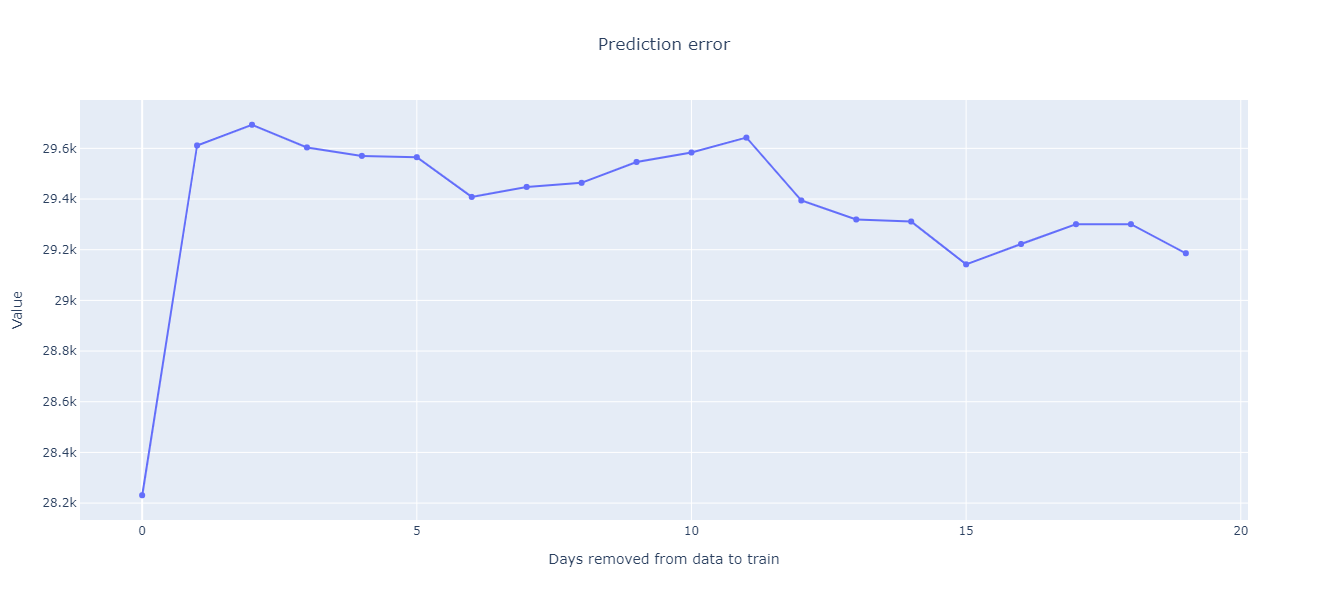

In [266]:
train('France', 20)